## Comparison Approach
This notebook loads each of the individual, trained models from the best runs of both Bert and CNN-based approaches. It will show the model.summary() and diagram, then will run a performance test by inferring results for the texts in the ClaimBuster dataset's crowdsourced.csv file. The file contains 22501 sentences. We will use sentences per second as the performance metric, and the on-disk size of each model as the complexity metric.

In [43]:
## Usual Imports
import numpy as np
import pandas as pd

from tensorflow import keras
import tensorflow.keras.backend as backend
from tensorflow.keras.preprocessing.sequence import pad_sequences

import string

import json
import pickle

import sys
sys.path.insert(0, '../python')
import debug
from jbyrne_utils import tokenize_sentences


# to fix the CUDA issues for CUDA 11.2 to allow use of the GPU
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/home/james/anaconda3/envs/w266/lib/python3.8/site-packages/tensorflow/python/client/session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [44]:
# load and parse the crowdsourced.csv file

cs = pd.read_csv("../data/crowdsourced.csv", delimiter=',', quotechar = '"', index_col='Sentence_id')

Unlike the curated json dataset we used for training, the "verdict" column takes three values:

| Verdict | Description |
| :---: | :--- |
| +1 | Checkable Fact Statements, e.g. "Inflation is down 2%" |
| 0 | Uncheckable Fact Statements, e.g. "Jack likes fish" |
| -1 | Non Fact Statements, e.g. "Drink the water" |

For the purposes of this paper, we are only interested in checkable fact statements, so we set any -1 verdicts to equal zero before tokenizing.

In [45]:
len(cs.loc[cs["Verdict"] == -1]["Verdict"])


14685

In [46]:
# Change -1 verdicts (non claim sentences) to be 0.
print(f"Before: {len(cs.loc[cs['Verdict'] == -1])} -1 labels.")

cs.loc[cs["Verdict"] == -1, "Verdict"] = 0

print(f"After:  {len(cs.loc[cs['Verdict'] == -1])} -1 labels.")

Before: 14685 -1 labels.
After:  0 -1 labels.


## Tokenize the new dataset
Provided this is run AFTER the other tests, there should be a tokenizer.pkl and embed_matrix.pkl already created from the training dataset.  We need to encode the new text using the same vocabulary and ID mapping as it will be input into a pre-trained embeddings layer in the models.

This function returns the tokenizer as well as the tokens, but we do not need it here as we are not training the embedding layer of the model.

In [47]:
tokens, _ = tokenize_sentences(cs["Text"], max_len=50 )

Loading previously created Tokenizer


In [48]:
with open('./best_models.pkl', 'rb') as f:
    best_models = pickle.load(f)
best_models

,timestamp,max_len,batch_size,embed_dim,num_filters,kernel_sizes,dense_layer_dims,dropout_rate,val_accuracy_best,val_accuracy_best_epoch
0,210409-210515,100,50,50,"[64, 64, 64]","[4, 8, 16]",[8],0.2,0.975588,8
1,210409-235328,50,50,50,"[96, 96, 96]","[8, 16, 32]",[8],0.2,0.976492,6
2,210410-004542,21,50,50,"[64, 64, 64]","[8, 12, 16]",[8],0.2,0.969259,14
3,210409-225707,17,50,50,"[96, 96, 96]","[8, 12, 16]",[32],0.2,0.970615,19


In [49]:
model = keras.models.load_model('../best_models/210409-114553')

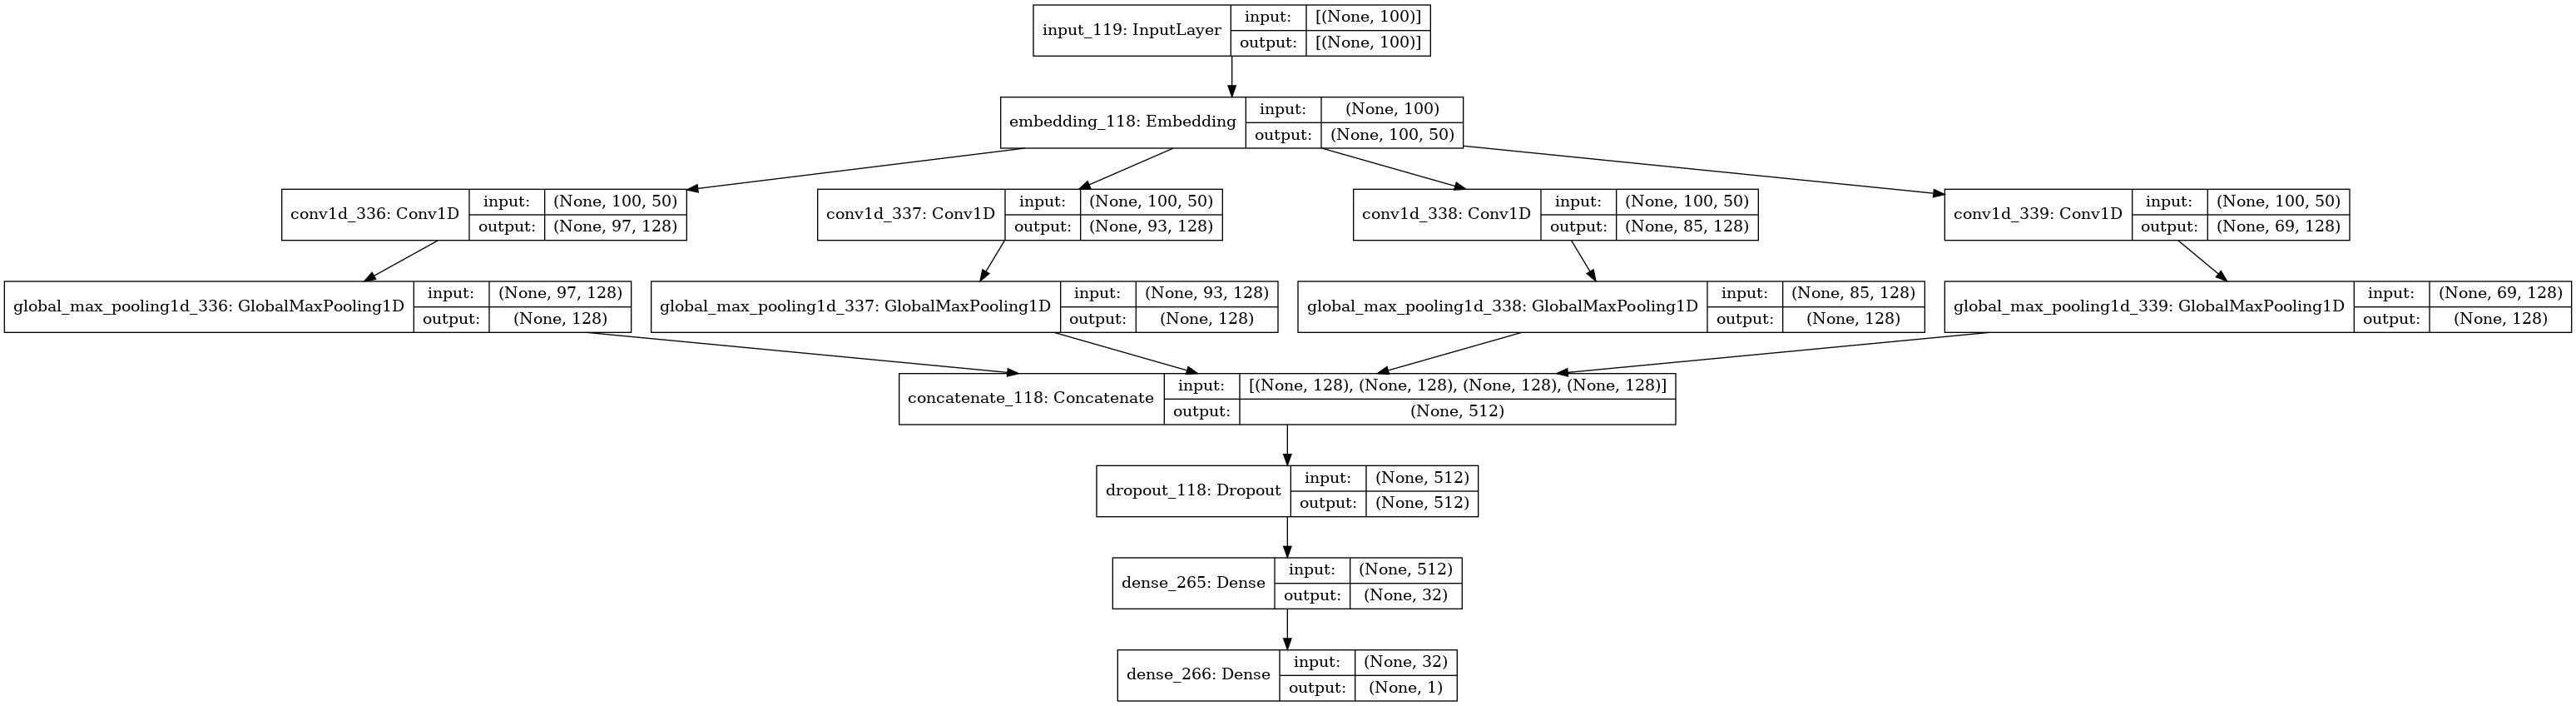

In [42]:
keras.utils.plot_model(model, '210409-114553.png', show_shapes=True)

In [39]:
trainable_count = np.sum([backend.count_params(w) for w in model.trainable_weights])
non_trainable_count = np.sum([backend.count_params(w) for w in model.non_trainable_weights])
(trainable_count, non_trainable_count, trainable_count+non_trainable_count)

(810761, 0.0, 810761.0)

### Citations
@inproceedings{arslan2020claimbuster,
    title={{A Benchmark Dataset of Check-worthy Factual Claims}},
    author={Arslan, Fatma and Hassan, Naeemul and Li, Chengkai and Tremayne, Mark },
    booktitle={14th International AAAI Conference on Web and Social Media},
    year={2020},
    organization={AAAI}
}

@article{meng2020gradient,
  title={Gradient-Based Adversarial Training on Transformer Networks for Detecting Check-Worthy Factual Claims},
  author={Meng, Kevin and Jimenez, Damian and Arslan, Fatma and Devasier, Jacob Daniel and Obembe, Daniel and Li, Chengkai},
  journal={arXiv preprint arXiv:2002.07725},
  year={2020}
}
